In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)
import sys
sys.path.append("..")
from pydynmod.grid import Grid, ForceGrid
from pydynmod.snap import SnapShot, ParticleType
import math
potential=None

1.2.0.dev20190725+cpu


In [3]:
snap=SnapShot('/Users/wegg/pydynmod/inputmodels/M85_0',omega=1.)
particletype = torch.full((snap.n,),ParticleType.Star,dtype=torch.uint8)
particletype[snap.particletype==0]=ParticleType.DarkMatter
snap.particletype = particletype

In [ ]:
vr = torch.tensordot(snap.positions[:,0:2],snap.velocities[:,0:2],dims=((-1,),(-1,))/torch.norm(snap.positions[:,0:2])
#vr = torch.tensordot(snap.positions[:,0:2],snap.velocities[:,0],dims=-1)/torch.norm(snap.positions[:,0:2])


In [4]:
stars = snap.stars
rcyl=torch.norm(stars.positions[:,0:2],dim=-1)
phi=torch.atan2(stars.positions[:,1],stars.positions[:,0])
vr=torch.einsum('...i,...i->...',stars.positions[:,0:2],stars.velocities[:,0:2])/rcyl
vt=(stars.positions[:,1]*stars.velocities[:,0] - stars.positions[:,0]*stars.velocities[:,1])/rcyl

In [ ]:
Integrating Bovy+19 Eq 2 over phi:
    omegab = dvr/dR dphi/dlog sigma + dphi/dlog sigma dlog sigma /dR  vr dphi/dlog sigma + (vt + dvt/dphi dphi/dlog sigma)/R

In [ ]:
omega m R <sigma>_m = <vR sigma>_m + d/dlogR <vR sigma>_m + m <vT sigma>_m
omega m R = <vR>_m + d/dlogR <vR>_m + m <vT>_m

In [12]:
surfdens.shape

(24, 360)

In [16]:
surfdensft = np.fft.fft(surfdens,axis=1)

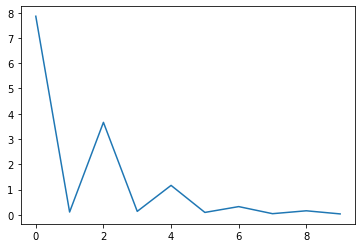

In [31]:
plt.plot(np.abs(surfdensft[5,0:10]))

In [227]:
patternspeed(snap.stars)

AttributeError: 'SnapShot' object has no attribute 'starrange'

In [226]:
def patternspeed(snap,rrange=(1,4),m=range(2,12,2)):
    rcyl=torch.norm(snap.stars.positions[:,0:2],dim=-1)
    phi=torch.atan2(snap.stars.positions[:,1],snap.stars.positions[:,0])
    vr=torch.einsum('...i,...i->...',snap.positions[:,0:2],snap.velocities[:,0:2])/rcyl
    vt=(snap.positions[:,1]*snap.velocities[:,0] - 
        snap.positions[:,0]*snap.velocities[:,1])/rcyl
    rbins=np.linspace(0.,10,50)
    phibins=np.linspace(-math.pi,math.pi,361)

    H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=snap.stars.masses)
    rmid = 0.5*(redges[:-1]+redges[1:])
    phimid = 0.5*(phiedges[:-1]+phiedges[1:])
    area = 0.5*(redges[1:,np.newaxis]**2 - redges[:-1,np.newaxis]**2)*(phiedges[np.newaxis,1:]-phiedges[np.newaxis,:-1])

    surfdens = H/area
    surfdensft = np.fft.fft(surfdens,axis=1)

    H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=snap.stars.masses*vr*rcyl)
    surfdensrvr = H/area
    surfdensrvrft = np.fft.fft(surfdensrvr,axis=1)

    dr=rbins[1]-rbins[0]
    dsurfdensrvr_drft = np.zeros_like(surfdensrvrft)
    dsurfdensrvr_drft[0,:] = (surfdensrvrft[1,:] - surfdensrvrft[0,:])/dr
    dsurfdensrvr_drft[-1,:] = (surfdensrvrft[-1,:] - surfdensrvrft[-2,:])/dr
    dsurfdensrvr_drft[1:-1,:] = (surfdensrvrft[2:,:] - surfdensrvrft[:-2])/(2*dr)

    H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=snap.stars.masses*vt)
    surfdensvt = H/area
    surfdensvtft = np.fft.fft(surfdensvt,axis=1)

    omegas=[]
    omegaerrs=[]
    i=(rmid>rrange[0]) & (rmid<rrange[1])
    for n in m:
        omega=surfdensvtft[:,n]/surfdensft[:,n]/rmid + 1j*dsurfdensrvr_drft[:,n]/surfdensft[:,n]/n/rmid
        omegas.append(np.mean(np.abs(omega[i])))
        omegaerrs.append(np.std(np.abs(omega[i]))/np.sqrt(np.sum(i)))
    return omegas,omegaerrs

def barlen(snap,phaselim=None,fractional_m2=None):
    barlens=()
    rcyl=torch.norm(snap.positions[:,0:2],dim=-1)
    phi=torch.atan2(snap.positions[:,1],snap.positions[:,0])
    rbins=np.linspace(0.,10,100)
    phibins=np.linspace(-math.pi,math.pi,361)
    H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=stars.masses)
    rmid = 0.5*(redges[:-1]+redges[1:])
    area = 0.5*(redges[1:,np.newaxis]**2 - redges[:-1,np.newaxis]**2)*(phiedges[np.newaxis,1:]-phiedges[np.newaxis,:-1])
    surfdens = H/area
    surfdensft = np.fft.fft(surfdens,axis=1)
    m2 = np.abs(surfdensft[:,2])/np.abs(surfdensft[:,0])
    ifid = np.argmax(m2)
    print(ifid,rmid[ifid])
    if phaselim is not None:
        ang = np.cumsum(np.angle(surfdensft[:,2],deg=True))/np.arange(1,len(surfdensft[:,2])+1)
        ang -= ang[ifid]
        plt.plot(rmid,np.abs(ang))
        barlens += (interplen(rmid,np.abs(ang),phaselim,ifid,'lt'),)
    if fractional_m2 is not None:
        barlens += (interplen(rmid,m2/m2[ifid],fractional_m2,ifid,'gt'),)
    return barlens

def interplen(r, vals, lim, ifid, comp='lt'):
    if comp == 'lt':   
        print(ifid)
        i = (vals>lim) #bad points
        i = np.min(i.nonzero()[0][i.nonzero()[0]>ifid])
    else:
        i = (vals<lim) #bad points
        i = np.min(i.nonzero()[0][i.nonzero()[0]>ifid])
    r0, val0 = rmid[i], vals[i]
    r1, val1 = rmid[i-1], vals[i-1]
    print(i, r0, val0, r1, val1)
    barlen = r1*(val0-lim)/(val0-val1) + r0*(lim-val1)/(val0-val1)
    return barlen


In [158]:
rcyl=torch.norm(snap.stars.positions[:,0:2],dim=-1)
phi=torch.atan2(snap.stars.positions[:,1],snap.stars.positions[:,0])
rbins=np.linspace(0.,10,50)
phibins=np.linspace(-math.pi,math.pi,361)

H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=snap.stars.masses)
rmid = 0.5*(redges[:-1]+redges[1:])
phimid = 0.5*(phiedges[:-1]+phiedges[1:])
area = 0.5*(redges[1:,np.newaxis]**2 - redges[:-1,np.newaxis]**2)*(phiedges[np.newaxis,1:]-phiedges[np.newaxis,:-1])

surfdens = H/area
surfdensft = np.fft.fft(surfdens,axis=1)

H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=snap.stars.masses*vr*rcyl)
surfdensrvr = H/area
surfdensrvrft = np.fft.fft(surfdensrvr,axis=1)

dr=rbins[1]-rbins[0]
dsurfdensrvr_drft = np.zeros_like(surfdensrvrft)
dsurfdensrvr_drft[0,:] = (surfdensrvrft[1,:] - surfdensrvrft[0,:])/dr
dsurfdensrvr_drft[-1,:] = (surfdensrvrft[-1,:] - surfdensrvrft[-2,:])/dr
dsurfdensrvr_drft[1:-1,:] = (surfdensrvrft[2:,:] - surfdensrvrft[:-2])/(2*dr)

H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=snap.stars.masses*vt)
surfdensvt = H/area
surfdensvtft = np.fft.fft(surfdensvt,axis=1)


surfdensvt[:,2]


array([3.74534388e-02, 5.24655985e-02, 4.10617138e-02, 2.29016314e-02,
       2.56257765e-02, 1.98529755e-02, 1.59802092e-02, 1.11906685e-02,
       9.36286321e-03, 8.31671229e-03, 6.88787172e-03, 5.87578051e-03,
       5.36536547e-03, 3.92679554e-03, 4.23137515e-03, 4.60466384e-03,
       3.27625263e-03, 2.81003635e-03, 2.79483739e-03, 3.48425369e-03,
       1.69463209e-03, 1.58833857e-03, 1.86209275e-03, 1.52946954e-03,
       1.12959777e-03, 1.62596276e-03, 8.98190174e-04, 1.27075445e-03,
       7.00208277e-04, 3.85937940e-04, 3.24179575e-04, 2.93456216e-04,
       5.37431494e-04, 3.01977410e-04, 1.30836551e-04, 1.70913548e-04,
       1.21472352e-04, 1.29487862e-04, 1.56010110e-04, 1.01511367e-04,
       0.00000000e+00, 1.13194455e-04, 3.80561854e-05, 3.29627832e-05,
       0.00000000e+00, 0.00000000e+00, 2.24164652e-05, 0.00000000e+00,
       0.00000000e+00])

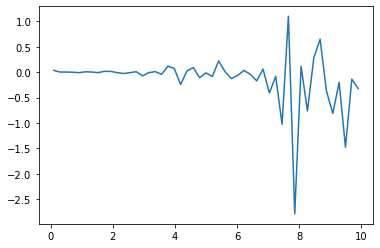

In [159]:
plt.plot(rmid,dsurfdensrvr_drft[:,2]/surfdensft[:,2]/2)

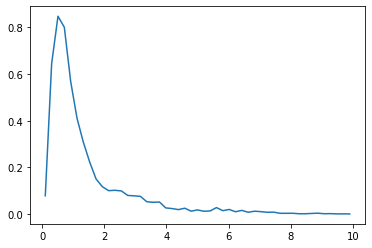

In [169]:
plt.plot(rmid,np.abs(surfdensrvrft[:,2]))

(0, 0.2)

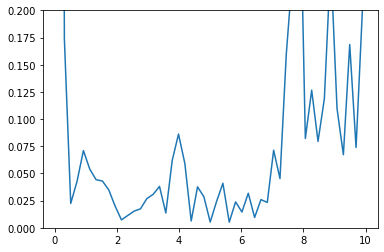

In [191]:
plt.plot(rmid,np.abs(dsurfdensrvr_drft[:,2]/surfdensft[:,2]/2/rmid))
plt.ylim([0,0.2])

2 0.11307775782745572 0.0010685555600073904 0.016028333400110856
4 0.1152995472275153 0.0009655987221032699 0.014483980831549044
6 0.11910086617993133 0.0020824979230232273 0.031237468845348407
8 0.1305792324071362 0.002579854559143181 0.03869781838714771
10 0.1582360205853056 0.0036590006802560138 0.054885010203840214


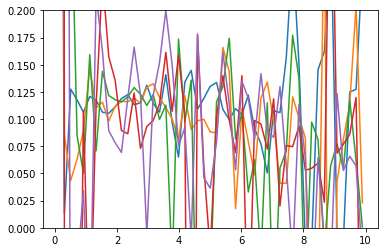

In [225]:
for n in range(2,12,2):
    omega=surfdensvtft[:,n]/surfdensft[:,n]/rmid + 1j*dsurfdensrvr_drft[:,n]/surfdensft[:,n]/n/rmid
    plt.plot(rmid,omega)
    plt.ylim(0,0.2)
    i=(rmid>1) & (rmid<4)
    print(n,np.mean(np.abs(omega[i])),np.std(np.abs(omega[i])/np.sum(i)),np.std(np.abs(omega[i])))


In [189]:
1j

1j

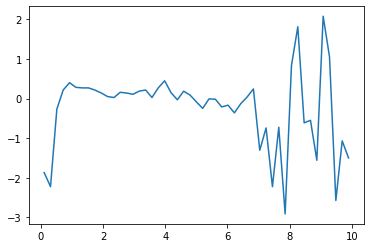

In [186]:
plt.plot(rmid,np.angle(omega))


In [ ]:
dsurfdensrvr_drft

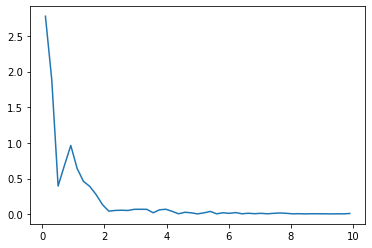

In [171]:
plt.plot(rmid,np.abs(dsurfdensrvr_drft[:,2]))

In [167]:
surfdensrvrft

array([[-3.51521977e-02+0.00000000e+00j,  4.39611781e-02+5.66773183e-02j,
        -1.53846350e-02-7.70527003e-02j, ...,
         9.79842337e-02-2.38518745e-02j, -1.53846350e-02+7.70527003e-02j,
         4.39611781e-02-5.66773183e-02j],
       [-8.17127027e-02+0.00000000e+00j, -1.24404945e-01+1.18394347e-01j,
        -1.08588841e-02-6.43698027e-01j, ...,
        -7.00451738e-03-2.67579285e-02j, -1.08588841e-02+6.43698027e-01j,
        -1.24404945e-01-1.18394347e-01j],
       [ 9.60538653e-03+0.00000000e+00j,  3.38365920e-02+7.53482252e-02j,
        -2.39092594e-02-8.46722101e-01j, ...,
        -3.75996694e-03-4.45827646e-02j, -2.39092594e-02+8.46722101e-01j,
         3.38365920e-02-7.53482252e-02j],
       ...,
       [ 1.40949034e-03+0.00000000e+00j,  1.22231356e-03-1.39678471e-04j,
        -1.12065175e-03-4.57234117e-05j, ...,
         1.39069322e-04-2.49723843e-05j, -1.12065175e-03+4.57234117e-05j,
         1.22231356e-03+1.39678471e-04j],
       [ 2.96955676e-03+0.00000000e+00j,  9.

In [166]:
dsurfdensrvr_drft[:,2]/surfdensft[:,2]/2/rmid

array([ 0.34080531-1.80462833e+00j,  0.00697014-1.73471456e-01j,
        0.00635659-2.14612553e-02j, -0.0017307 +4.28239510e-02j,
       -0.0102692 +7.02486792e-02j,  0.00677009+5.35824463e-02j,
        0.00208863+4.42160588e-02j, -0.00594804+4.26203365e-02j,
        0.00985185+3.34203927e-02j,  0.00744094+1.85397281e-02j,
       -0.00403422+6.08331963e-03j, -0.01130941+9.80838160e-04j,
       -0.00359816+1.49436773e-02j,  0.00361734+1.70706300e-02j,
       -0.02461047+1.06235268e-02j, -0.0024292 +3.06683710e-02j,
        0.00328492+3.79214634e-02j, -0.01150804+7.32549344e-03j,
        0.03124367+5.33561752e-02j,  0.01841676+8.42122434e-02j,
       -0.05786513+1.18210789e-02j,  0.00567062-2.72664934e-03j,
        0.01952695+3.22006409e-02j, -0.02267165+1.72913654e-02j,
       -0.00278786-4.53673434e-03j, -0.01656906-1.76386632e-02j,
        0.04091144+1.83735662e-03j,  0.00203607+4.77055577e-03j,
       -0.02162009-1.00381481e-02j, -0.01075504-9.74814271e-03j,
        0.00576401-3.1290

(-0.5, 0.5)

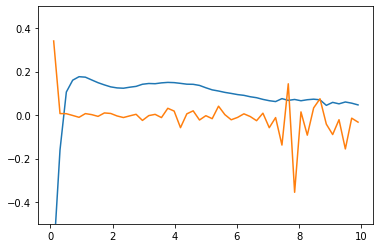

In [160]:
plt.plot(rmid,surfdensvtft[:,2]/surfdensft[:,2]/rmid)
plt.plot(rmid,dsurfdensrvr_drft[:,2]/surfdensft[:,2]/2/rmid)
plt.ylim([-0.5,0.5])

(-0.5, 0.5)

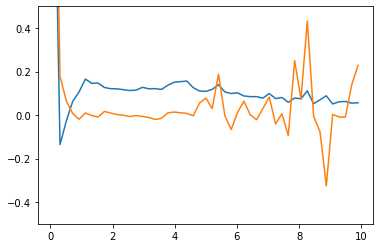

In [162]:
plt.plot(rmid,surfdensvtft[:,4]/surfdensft[:,4]/rmid)
plt.plot(rmid,dsurfdensrvr_drft[:,4]/surfdensft[:,4]/4/rmid)
plt.ylim([-0.5,0.5])

In [ ]:
print()

4.875 4.625 99 9 0.9888888888888889 0.011111111111111112


4.627777777777777

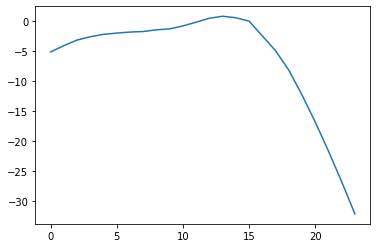

In [76]:
anglim=10
ang = np.cumsum(np.angle(surfdensft[:,2],deg=True))/np.arange(1,len(surfdensft[:,2])+1)
i=np.argmax(np.abs(ang)>10)
r0,ang0=rmid[i],np.abs(ang[i])
r1,ang1=rmid[i-1],np.abs(ang[i-1])
barlen = r1*(ang0-10)/(ang0-ang1) + r0*(10-ang1)/(ang0-ang1)



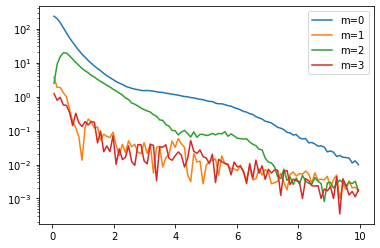

In [79]:
surfdensft = np.fft.fft(surfdens,axis=1)
plt.plot(rmid,np.abs(surfdensft[:,0]),label='m=0')
plt.plot(rmid,np.abs(surfdensft[:,1]),label='m=1')
plt.plot(rmid,np.abs(surfdensft[:,2]),label='m=2')
plt.plot(rmid,np.abs(surfdensft[:,3]),label='m=3')
plt.legend()

plt.yscale('log')

In [77]:
rbins=np.linspace(0.,10,100)
phibins=np.linspace(-math.pi,math.pi,361)
rmid = 0.5*(redges[:-1]+redges[1:])
phimid = 0.5*(phiedges[:-1]+phiedges[1:])

H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=stars.masses)
area = 0.5*(redges[1:,np.newaxis]**2 - redges[:-1,np.newaxis]**2)*(phiedges[np.newaxis,1:]-phiedges[np.newaxis,:-1])
surfdens = H/area

H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=stars.masses*vr*rcyl)
surfdensrvr = H/area

H,redges,phiedges = np.histogram2d(rcyl.numpy(),phi.numpy(),(rbins,phibins),weights=stars.masses*vt)
surfdensvt = H/area

rmid = 0.5*(redges[:-1]+redges[1:])
phimid = 0.5*(phiedges[:-1]+phiedges[1:])


In [83]:
surfdens.shape,rbins.shape,phibins.shape

((24, 15), (25,), (16,))

In [111]:
dphi=phibins[1]-phibins[0]
dsurfdens_dphi = np.zeros_like(surfdens)
dsurfdens_dphi[:,0] = (surfdens[:,1] - surfdens[:,-1])/(2*dphi)
dsurfdens_dphi[:,-1] = (surfdens[:,0] - surfdens[:,-2])/(2*dphi)
dsurfdens_dphi[:,1:-1] = (surfdens[:,2:] - surfdens[:,:-2])/(2*dphi)

dsurfdensvt_dphi = np.zeros_like(surfdens)
dsurfdensvt_dphi[:,0] = (surfdensvt[:,1] - surfdensvt[:,-1])/(2*dphi)
dsurfdensvt_dphi[:,-1] = (surfdensvt[:,0] - surfdensvt[:,-2])/(2*dphi)
dsurfdensvt_dphi[:,1:-1] = (surfdensvt[:,2:] - surfdensvt[:,:-2])/(2*dphi)

dr=rbins[1]-rbins[0]
dsurfdensrvr_dr = np.zeros_like(surfdens)
dsurfdensrvr_dr[0,:] = (surfdensrvr[1,:] - surfdensrvr[0,:])/dphi
dsurfdensrvr_dr[-1,:] = (surfdensrvr[-1,:] - surfdensrvr[-2,:])/dphi
dsurfdensrvr_dr[1:-1,:] = (surfdensrvr[2:,:] - surfdensrvr[:-2])/(2*dphi)

rmid = 0.5*(redges[:-1]+redges[1:])
phimid = 0.5*(phiedges[:-1]+phiedges[1:])

rhs = - dsurfdensrvr_dr/rmid[:,np.newaxis] + dsurfdensvt_dphi/rmid[:,np.newaxis]
omega = rhs/dsurfdens_dphi

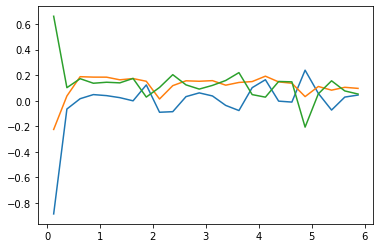

In [112]:
plt.plot(rmid,np.mean(dsurfdensrvr_dr/rmid[:,np.newaxis]/dsurfdens_dphi,1))
plt.plot(rmid,np.mean(dsurfdensvt_dphi/rmid[:,np.newaxis]/dsurfdens_dphi,1))
plt.plot(rmid,np¸omega,1))

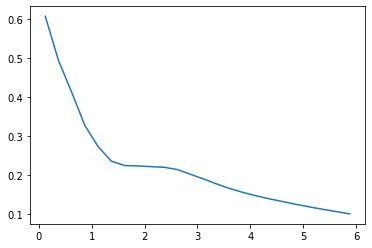

In [117]:
plt.plot( rmid,np.mean(surfdensvt/surfdens/rmid[:,np.newaxis],1) )
np.mean(dsurfdensrvr_dr,1)

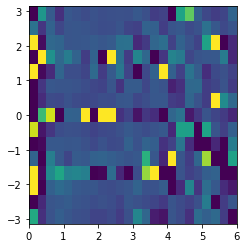

In [113]:
plt.imshow(omega.T,extent=(redges.min(),redges.max(),phiedges.min(),phiedges.max()),vmin=0,vmax=0.5)

(array([ 2.,  1.,  0.,  0.,  0.,  2.,  2.,  0.,  1.,  1.,  5.,  3.,  3.,
         5.,  3.,  3.,  3., 11.,  8.,  8., 14., 12., 13., 19., 19., 28.,
        19., 16.,  8.,  6.,  7., 12.,  8.,  4.,  3.,  4.,  4.,  2.,  2.,
         0.,  1.,  4.,  1.,  1.,  2.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  2.,  3.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.00505051, 0.01010101, 0.01515152, 0.02020202,
        0.02525253, 0.03030303, 0.03535354, 0.04040404, 0.04545455,
        0.05050505, 0.05555556, 0.06060606, 0.06565657, 0.07070707,
        0.07575758, 0.08080808, 0.08585859, 0.09090909, 0.0959596 ,
        0.1010101 , 0.10606061, 0.11111111, 0.11616162, 0.12121212,
        0.12626263, 0.13131313, 0.13636364, 0.14141414, 0.14646465,
        0.15151515, 0.15656566,

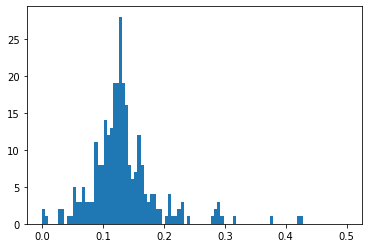

In [115]:
plt.hist(omega[3:,:].flatten(),np.linspace(0,0.5,100))

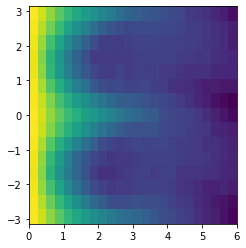

In [110]:
plt.imshow(np.log(surfdens.T),extent=(redges.min(),redges.max(),phiedges.min(),phiedges.max()))

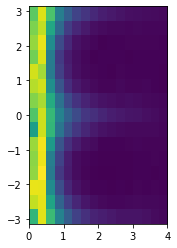

In [39]:
plt.imshow(surfdensvt.T,extent=(redges.min(),redges.max(),phiedges.min(),phiedges.max()))

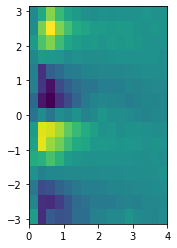

In [40]:
plt.imshow(surfdensrvr.T,extent=(redges.min(),redges.max(),phiedges.min(),phiedges.max()))

In [21]:
redges.shape,redgesmat.shape,H.shape

((17,), (17, 16), (16, 15))

In [14]:
redges,phiedges

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  ]),
 array([0.        , 0.41887902, 0.83775804, 1.25663706, 1.67551608,
        2.0943951 , 2.51327412, 2.93215314, 3.35103216, 3.76991118,
        4.1887902 , 4.60766923, 5.02654825, 5.44542727, 5.86430629,
        6.28318531]))

In [3]:
torch.norm(snap.positions[:,0:2],dim=-1)

tensor([ 2.4432,  4.0561,  3.1959,  ...,  8.3834, 19.3650, 26.9471])

In [3]:
potential=ForceGrid(n=(256,256,256),
                    gridedges=torch.tensor([10.,10.,10.],dtype=torch.float32),
                    smoothing=0.3*20/256)
_=potential.griddata(snap.positions,weights=snap.masses,method='cic')
potential.grid_accelerations()

In [4]:
import copy
maxt=50
nt=1001
nparticles=100
smallsnap = copy.deepcopy(snap[0:nparticles])
smallsnap.dt=torch.full_like(smallsnap.masses,1.)
tvec = torch.linspace(0.,maxt,nt)
positions = torch.zeros(nt,nparticles,3)
velocities = torch.zeros(nt,nparticles,3)
for i,time in enumerate(tvec):
    if i % 100 == 1:
        print(time)
        verbose=True
    else:
        verbose=False
    smallsnap.integrate(time=time,potential=potential,verbose=verbose)
    positions[i,:,:] = smallsnap.positions
    velocities[i,:,:] = smallsnap.velocities

tensor(0.0500)
tensor(1, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0500) tensor(100)
tensor(2, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0250) tensor(78)
tensor(4, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0125) tensor(66)
tensor(8, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0063) tensor(57)
tensor(16, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0031) tensor(46)
tensor(32, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0016) tensor(35)
tensor(64, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0008) tensor(13)
tensor(5.0500)
tensor(1, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0500) tensor(18)
tensor(2, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0250) tensor(12)
tensor(4, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0125) tensor(1)
tensor(8, dtype=torch.int32) tensor(65536, dtype=torch.int32) tensor(0.0063) tensor(0)


In [7]:
positions[3,0:10,:]

tensor([[-2.0375,  1.3206,  1.1655],
        [ 4.0019, -0.5713,  0.0163],
        [ 3.2094, -0.1910, -0.7169],
        [ 0.2174,  0.0919,  0.0338],
        [-4.0037, -4.1453, -0.3171],
        [ 0.2315, -0.0435,  0.1022],
        [-1.0195,  0.1709, -0.5962],
        [-1.8244, -2.9542, -0.5832],
        [-1.3900,  0.4180,  0.1441],
        [ 2.7295, -1.2486,  0.0880]])

In [ ]:
vr = torch.tensordot(snap.positions[:,0:2],snap.velocities[:,0],dims=-1)/torch.norm(snap.positions[:,0:2])

In [9]:
smallsnap.CoRotatingFrame(0.2,0.1,positions[3,0:10,:])

tensor([[-2.0107,  1.3611,  1.1655],
        [ 3.9897, -0.6512,  0.0163],
        [ 3.2049, -0.2552, -0.7169],
        [ 0.2192,  0.0875,  0.0338],
        [-4.0858, -4.0644, -0.3171],
        [ 0.2306, -0.0482,  0.1022],
        [-1.0159,  0.1913, -0.5962],
        [-1.8832, -2.9172, -0.5832],
        [-1.3814,  0.4457,  0.1441],
        [ 2.7040, -1.3029,  0.0880]])

In [6]:
%debug

> /Users/wegg/pydynmod/pydynmod/snap.py(187)CoRotatingFrame()
    185                            device=positions.device)
    186 
--> 187         corotpositions[...,0:2] = R @ positions[...,0:2]
    188         if velocities is None:
    189             return corotpositions

ipdb> positions[...,0:2].shape
torch.Size([100, 2])
ipdb> R @ positions[...,0:2]
*** RuntimeError: size mismatch, m1: [2 x 2], m2: [100 x 2] at /Users/distiller/project/conda/conda-bld/pytorch-nightly_1564031645046/work/aten/src/TH/generic/THTensorMath.cpp:752
ipdb> R @ positions[0,0:2]
tensor([-0.9359,  2.2404])
ipdb> R[None,...] @ positions[0,0:2]
tensor([[-0.9359,  2.2404]])
ipdb> R[None,...] @ positions[...,0:2]
*** RuntimeError: size mismatch, m1: [2 x 2], m2: [100 x 2] at /Users/distiller/project/conda/conda-bld/pytorch-nightly_1564031645046/work/aten/src/TH/generic/THTensorMath.cpp:752
ipdb> R[None,...]
tensor([[[ 0.8253,  0.5646],
         [-0.5646,  0.8253]]])
ipdb> R[None,...].shape
torch.Size([1, 2, 2]

ipdb> corotpositions[...,0:2] = R @ positions[...,0:2,None]
*** RuntimeError: expand(torch.FloatTensor{[100, 2, 1]}, size=[100, 2]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)
ipdb> corotpositions[...,0:2] = R @ positions[...,0:2,None]
*** RuntimeError: expand(torch.FloatTensor{[100, 2, 1]}, size=[100, 2]): the number of sizes provided (2) must be greater or equal to the number of dimensions in the tensor (3)
ipdb> corotpositions[...,0:2] = (R @ positions[...,0:2,None])[...,0]
ipdb> q


In [89]:
positions

tensor([[[-2.0755e+00,  1.2890e+00,  1.1675e+00],
         [ 4.0276e+00, -4.7943e-01,  2.0697e-02],
         [ 3.1949e+00, -7.9168e-02, -7.2240e-01],
         ...,
         [-7.9021e-01, -9.7775e-01,  6.1242e-01],
         [ 1.7390e-01, -1.9080e-01,  4.5154e-02],
         [ 2.6535e+00,  5.5634e+00, -9.2635e-01]],

        [[-2.0569e+00,  1.3052e+00,  1.1670e+00],
         [ 4.0193e+00, -5.1008e-01,  1.9197e-02],
         [ 3.2026e+00, -1.3515e-01, -7.2003e-01],
         ...,
         [-8.4528e-01, -9.7375e-01,  5.9784e-01],
         [-5.6385e-02,  1.4474e-01, -5.7390e-02],
         [ 2.6758e+00,  5.5577e+00, -9.2188e-01]],

        [[-2.0473e+00,  1.3130e+00,  1.1663e+00],
         [ 4.0107e+00, -5.4070e-01,  1.7713e-02],
         [ 3.2061e+00, -1.6311e-01, -7.1855e-01],
         ...,
         [-8.5764e-01, -9.7002e-01,  5.9205e-01],
         [-9.2376e-02,  1.8008e-01, -5.0656e-02],
         [ 2.6981e+00,  5.5519e+00, -9.1736e-01]],

        ...,

        [[-1.0633e-01,  5.4197e-01, -6

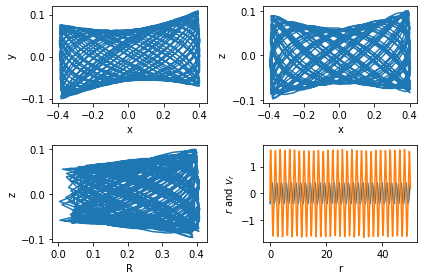

In [88]:
idx=47
f,ax = plt.subplots(2,2)

ax[0,0].plot(positions[:,idx,0],positions[:,idx,1])
ax[0,0].set_xlabel('x')
ax[0,0].set_ylabel('y')

ax[0,1].plot(positions[:,idx,0],positions[:,idx,2])
ax[0,1].set_xlabel('x')
ax[0,1].set_ylabel('z')

ax[1,0].plot( (positions[:,idx,0]**2 + positions[:,idx,1]**2).sqrt(),positions[:,idx,2])
ax[1,0].set_xlabel('R')
ax[1,0].set_ylabel('z')

ax[1,1].plot(tvec,positions[:,idx,0])
ax[1,1].plot(tvec,velocities[:,idx,0])
ax[1,1].set_xlabel('r')
ax[1,1].set_ylabel('$r$ and $v_r$')
f.tight_layout()

In [25]:
device='cpu'
gpusnap=snap.to(device)
gpupotential=potential.to(device)
tvec = torch.linspace(0.,100,101,device=device)
for i,time in enumerate(tvec):
    print(time)
    gpusnap.integrate(time=time,potential=gpupotential,verbose=True)

NameError: name 'potential' is not defined

In [112]:
import math
def circular_velocity(potential,rvec=torch.linspace(0,10,100),thetavec=torch.linspace(0,math.pi,60)):
    r,theta=torch.meshgrid(rvec,thetavec)
    x,y,z=r*torch.sin(theta),r*torch.cos(theta),torch.zeros_like(r)
    posvcirc=torch.stack((x.flatten(),y.flatten(),z.flatten()),dim=0).t()
    accvcirc=potential.get_accelerations(posvcirc)
    accvcirc=accvcirc.view(r.shape+(3,))
    fr = (accvcirc[...,0]*x + accvcirc[...,1]*y + accvcirc[...,2]*z)/r
    vcirc = (fr.mean(dim=1)*rvec).sqrt()
    return vcirc

In [148]:
dmpotential=ForceGrid(n=(128,128,128),
                    gridedges=torch.tensor([10.,10.,10.],dtype=torch.float32),
                    smoothing=0.3*20/256)
_=dmpotential.griddata(snap.dm.positions,weights=snap.dm.masses,method='cic')
dmpotential.grid_accelerations()
stellarpotential=ForceGrid(n=(128,128,128),
                    gridedges=torch.tensor([10.,10.,10.],dtype=torch.float32),
                    smoothing=0.3*20/256)
_=stellarpotential.griddata(snap.stars.positions,weights=snap.stars.masses,method='cic')
stellarpotential.grid_accelerations()

getter
getter
getter
getter


getter
getter
getter
getter


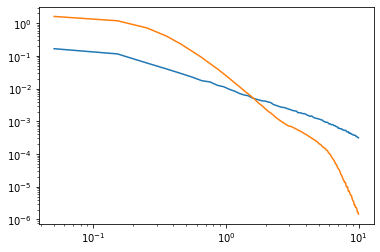

In [147]:
rbins = np.linspace(0,10,100)
H,edges = np.histogram(snap.dm.r,rbins,weights=snap.dm.masses)
vol=4*np.pi/3*(edges[1:]**3-edges[:-1]**3)
mid=0.5*(edges[1:]+edges[:-1])
plt.loglog(mid,H/vol)
H,edges = np.histogram(snap.stars.r,rbins,weights=snap.stars.masses)
vol=4*np.pi/3*(edges[1:]**3-edges[:-1]**3)
mid=0.5*(edges[1:]+edges[:-1])
plt.loglog(mid,H/vol)

(0, 2.5)

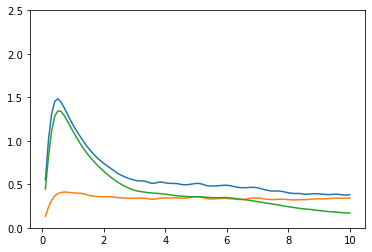

In [152]:
rvec=torch.linspace(0,10,100)
plt.plot(rvec,circular_velocity(potential,rvec))
plt.plot(rvec,circular_velocity(dmpotential,rvec))
plt.plot(rvec,circular_velocity(stellarpotential,rvec))
plt.ylim([0,2.5])

getter
getter
getter


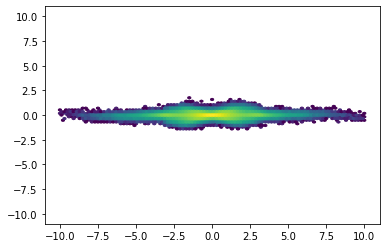

In [129]:
plt.hexbin(snap.stars.x,snap.stars.z,C=snap.stars.masses,
           bins='log',reduce_C_function=np.sum,extent=(-10,10,-10,10))

getter
getter
getter


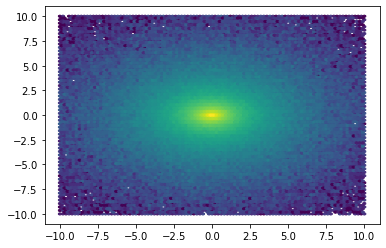

In [130]:
plt.hexbin(snap.dm.x,snap.dm.z,C=snap.dm.masses,
           bins='log',reduce_C_function=np.sum,extent=(-10,10,-10,10))

In [20]:
%%timeit
acc=grid.get_acc(positions)

370 ms ± 6.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
testpos=torch.tensor([[0.,0.,0.]],dtype=torch.float32)
grid=ForceGrid(n=(256,256,256),gridedges=torch.tensor([10.,10.,10.],dtype=torch.float32),smoothing=0.3*20/256)
_=grid.griddata(testpos,method='cic')
grid.grid_acc()
grid.get_acc(torch.tensor([[-9.9,0.,0.]],dtype=torch.float32))

tensor([-2.0616e-03, -2.3009e-09, -7.4216e-09])

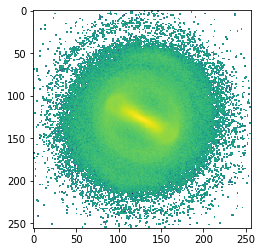

In [10]:
plt.imshow(torch.log(rho.sum(2).type(torch.float)).transpose(0,1))


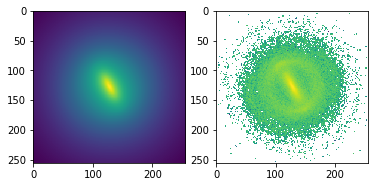

In [74]:
f,ax = plt.subplots(1,2)
ax[0].imshow(pot[:,:,128].log())
ax[1].imshow(rho[:,:,128].log())